In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [15]:
%load_ext tensorboard

# load tensorflow dependencies
import tensorflow as tf

# 16 bit precision computing
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.layers import Cropping2D
print(tf.__version__)
print(tf.config.experimental.list_physical_devices())

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import skimage.io
import sys

from sklearn.model_selection import StratifiedKFold
import time

sys.path.insert(0,'..')

# custom packages
from preprocessing.utils.data_loader import PandasDataLoader
from preprocessing.generators import TiffGenerator, TiffFromCoords, UNETGenerator
from preprocessing.utils.mat_transforms import tf_tile2mat, tf_tile2square
from utils.utils import set_gpu_memory, seed_all

from preprocessing.utils.data_loader import PandasDataLoader


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.2.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
seed_all(20)
DATA_DIR = Path('../data/')

# control for the gpu memory, and number of used gpu's
set_gpu_memory(device_type='GPU')
# see the utils functions which seeds are set
# tensorflow ops still have to be seeded manually...
seed_all()

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

1 Physical GPUs, 1 Logical GPUs
Compute dtype: float16
Variable dtype: float32


## Initialization

In [8]:
# ------------------
# Directories
# ------------------
DATA_DIR = '../data'  # General path to the data dir
IMG_DIR = '../data/train_images'  # Path to the TILED images
TRAIN_MASKS_DIR = '../data/train_label_masks'  # Path to the masks
TIFF_LEVEL = 1

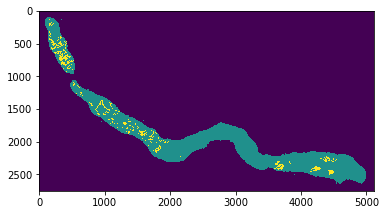

In [9]:
mask_paths = Path(TRAIN_MASKS_DIR).rglob('*.tiff')
mask_paths = list(mask_paths)
mask = skimage.io.MultiImage(str(mask_paths[50]))[1]
plt.imshow(mask[:,:,0])

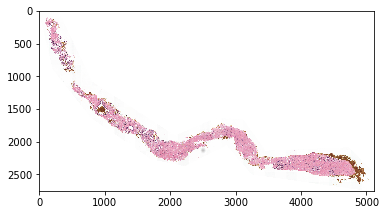

In [10]:
image_paths = Path(IMG_DIR).rglob('*.tiff')
image_paths = list(image_paths)
image = skimage.io.MultiImage(str(image_paths[50]))[1]
plt.imshow(image)

In [42]:
# an example: loading the skip dataframe and listing the possible reasons
NFOLDS=4
SEED=1
TRAIN_FOLD=0
skip_df = pd.read_csv(Path(DATA_DIR) / Path('PANDA_Suspicious_Slides_15_05_2020.csv'))
print("possible faulty slide reasons", skip_df['reason'].unique())

fold_df = PandasDataLoader(images_csv_path=Path(DATA_DIR) / Path('train.csv'),
                           skip_csv=Path(DATA_DIR) / Path('PANDA_Suspicious_Slides_15_05_2020.csv'), 
                           skip_list=['No Mask'])

# we create a possible stratification here, the options are by isup grade, or further distilled by isup grade and data provider
# stratified_isup_sample or stratified_isup_dp_sample, we use the former.

fold_df = fold_df.stratified_isup_sample(NFOLDS, SEED)

# we can create training/validation splits from the fold column
train_df = fold_df[fold_df['split'] != TRAIN_FOLD]
valid_df = fold_df[fold_df['split'] == TRAIN_FOLD]

img_ids = [x.stem for x in image_paths]
img_df = pd.DataFrame({'paths': image_paths, 'image_id': img_ids})

mask_ids = [x.stem.split('_')[0] for x in mask_paths]
mask_df = pd.DataFrame({'paths': mask_paths, 'image_id': mask_ids})

train_df = train_df.merge(img_df, on='image_id')
train_df = train_df.merge(mask_df, on='image_id')
valid_df = valid_df.merge(img_df, on='image_id')
valid_df = valid_df.merge(mask_df, on='image_id')

display(train_df)
display(valid_df)

filtered_img_paths_train = [str(x) for x in train_df['paths_x'].tolist()]
filtered_mask_paths_train = [str(x) for x in train_df['paths_y'].tolist()]
filtered_data_providers_train = train_df['data_provider'].to_list()

filtered_img_paths_valid = [str(x) for x in valid_df['paths_x'].tolist()]
filtered_mask_paths_valid = [str(x) for x in valid_df['paths_y'].tolist()]
filtered_data_providers_valid = valid_df['data_provider'].to_list()

possible faulty slide reasons ['marks' 'No Mask' 'Background only'
 'No cancerous tissue but ISUP Grade > 0' 'tiss' 'blank']
********************
The training dataframe shape before filtering:(10616, 4)
The skip dataframe has shape: (675, 2), with reasons ['marks', 'No Mask', 'Background only', 'No cancerous tissue but ISUP Grade > 0', 'tiss', 'blank']
Filtering based on the following columns: ['No Mask']
number of duplicates in the skip df: (0, 2)
Training dataframe after filtering: (10516, 4)
Number of rows removed by filter: 100
********************


,image_id,data_provider,isup_grade,gleason_score,split,paths_x,paths_y
0,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,2,../data/train_images/000920ad0b612851f8e01bcc8...,../data/train_label_masks/000920ad0b612851f8e0...
1,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1,../data/train_images/0018ae58b01bdadc8e347995b...,../data/train_label_masks/0018ae58b01bdadc8e34...
2,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,3,../data/train_images/001c62abd11fa4b57bf7a6c60...,../data/train_label_masks/001c62abd11fa4b57bf7...
3,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,1,../data/train_images/001d865e65ef5d2579c190a0e...,../data/train_label_masks/001d865e65ef5d2579c1...
4,003046e27c8ead3e3db155780dc5498e,karolinska,1,3+3,2,../data/train_images/003046e27c8ead3e3db155780...,../data/train_label_masks/003046e27c8ead3e3db1...
...,...,...,...,...,...,...,...
7882,ffcd99c47e57ad2934dc6bbf5edf6675,karolinska,0,0+0,1,../data/train_images/ffcd99c47e57ad2934dc6bbf5...,../data/train_label_masks/ffcd99c47e57ad2934dc...
7883,ffcee00fd033d3ece1408035a7fd4ea7,karolinska,1,3+3,3,../data/train_images/ffcee00fd033d3ece1408035a...,../data/train_label_masks/ffcee00fd033d3ece140...
7884,ffe06afd66a93258f8fabdef6044e181,radboud,0,negative,1,../data/train_images/ffe06afd66a93258f8fabdef6...,../data/train_label_masks/ffe06afd66a93258f8fa...
7885,ffe236a25d4cbed59438220799920749,radboud,2,3+4,3,../data/train_images/ffe236a25d4cbed5943822079...,../data/train_label_masks/ffe236a25d4cbed59438...


,image_id,data_provider,isup_grade,gleason_score,split,paths_x,paths_y
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,0,../data/train_images/0005f7aaab2800f6170c39969...,../data/train_label_masks/0005f7aaab2800f6170c...
1,002a4db09dad406c85505a00fb6f6144,karolinska,0,0+0,0,../data/train_images/002a4db09dad406c85505a00f...,../data/train_label_masks/002a4db09dad406c8550...
2,0032bfa835ce0f43a92ae0bbab6871cb,karolinska,1,3+3,0,../data/train_images/0032bfa835ce0f43a92ae0bba...,../data/train_label_masks/0032bfa835ce0f43a92a...
3,006f4d8d3556dd21f6424202c2d294a9,karolinska,0,0+0,0,../data/train_images/006f4d8d3556dd21f6424202c...,../data/train_label_masks/006f4d8d3556dd21f642...
4,006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3,0,../data/train_images/006f6aa35a78965c92fffd1fb...,../data/train_label_masks/006f6aa35a78965c92ff...
...,...,...,...,...,...,...,...
2624,ff811b8f07ef6d31cb60dbd6ad7b0f6c,radboud,0,negative,0,../data/train_images/ff811b8f07ef6d31cb60dbd6a...,../data/train_label_masks/ff811b8f07ef6d31cb60...
2625,ffc005d56a21efbd034425623f596984,karolinska,2,3+4,0,../data/train_images/ffc005d56a21efbd034425623...,../data/train_label_masks/ffc005d56a21efbd0344...
2626,ffcbb41626c9267c5c20c4804bd5639a,radboud,4,3+5,0,../data/train_images/ffcbb41626c9267c5c20c4804...,../data/train_label_masks/ffcbb41626c9267c5c20...
2627,ffd2841373b39792ab0c84cccd066e31,radboud,0,negative,0,../data/train_images/ffd2841373b39792ab0c84ccc...,../data/train_label_masks/ffd2841373b39792ab0c...


## Unet Generator

In [43]:
A = UNETGenerator(filtered_img_paths_train, 
                  filtered_mask_paths_train, 
                  filtered_data_providers_train,
                  ksize=(256, 256),
                  mode='training')

In [44]:
z = A.load_process()

for i,(x,y) in enumerate(z.take(1)):
    print(x.shape, y.shape)

(16, 256, 256, 3) (16, 256, 256, 3)


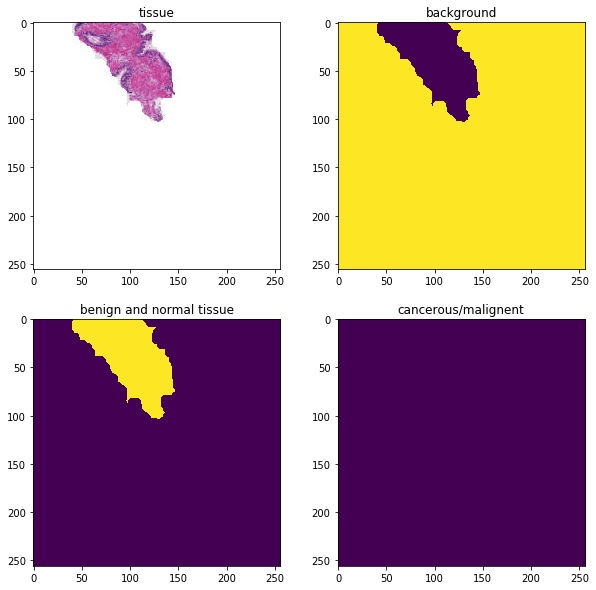

In [45]:
idx = 6
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].imshow(x[idx,...])
ax[0,0].set_title('tissue')
ax[0,1].imshow(y[idx,...,0])
ax[0,1].set_title('background')
ax[1,0].imshow(y[idx,...,1])
ax[1,0].set_title('benign and normal tissue')
ax[1,1].imshow(y[idx,...,2])
ax[1,1].set_title('cancerous/malignent')

plt.show()

## UNET architecture

In [208]:
from model.unet.unet_tfkeras import unet
from model.unet.loss import generalized_dice_loss
from model.unet.metric import MeanIoU_prob
from model.layers import WeightLayer
from tensorflow.keras.models import Model

model = unet()

from tensorflow.keras.optimizers import Adam


IOU_metric = MeanIoU_prob(3)
    
model.compile(optimizer=Adam(lr=0.0001), 
              loss=[ generalized_dice_loss], 
              metrics=[IOU_metric, 'accuracy'])


In [209]:
model.load_weights('unet.h5')
#model.fit(z, epochs=1, steps_per_epoch=1000)


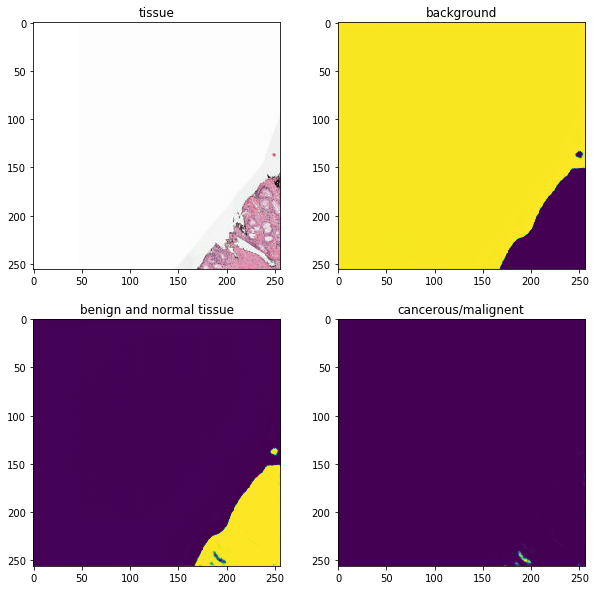

In [210]:
pred=model.predict(1-x)
idx = 1
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].imshow(x[idx,...])
ax[0,0].set_title('tissue')
ax[0,1].imshow(pred[idx,...,0])
ax[0,1].set_title('background')
ax[1,0].imshow(pred[idx,...,1])
ax[1,0].set_title('benign and normal tissue')
ax[1,1].imshow(pred[idx,...,2])
ax[1,1].set_title('cancerous/malignent')

plt.show()

In [211]:
layer = WeightLayer()(model.outputs)
new_model = Model(inputs=model.inputs, outputs=layer)


In [229]:
inference_generator = UNETGenerator(filtered_img_paths[0:10], 
                  filtered_mask_paths[0:10], 
                  filtered_data_providers[0:10],
                  ksize=(256, 256),
                  mode='inference')

inference_generator = inference_generator.load_process()

(1, 1840, 1728, 3)
crops tf.Tensor([  0 208   0  64], shape=(4,), dtype=int64)
before crop (1, 2048, 1792, 3)
after crop (1, 1840, 1728, 3)


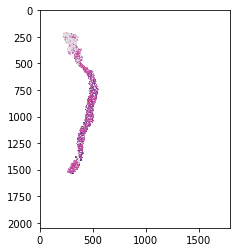

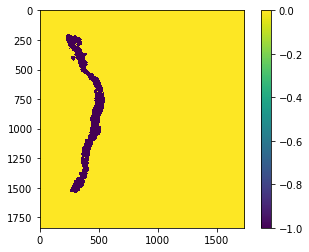

In [251]:
for x in inference_generator.take(1):
    crops = tf.squeeze(x[1])
    preds = new_model.predict(1-x[0])
    result = UNETGenerator.crop(preds, crops)
    
print("crops", crops)
print("before crop", x[0].shape)
print("after crop", result.shape)  

plt.imshow(x[0][0,...])
plt.figure()
plt.imshow(result.numpy().astype('float32')[0,...,1])
plt.colorbar()

## Comparing Tiling approaches

The tiling order is different, but largely they collect the same samples.
The Unet tiling method can be more effective for level 0 images, since the number of tiles can only be small
due to its resolution. In that area, it might have an advantage.

In [268]:
# TODO: test this function
def tile(img,sz, N, pad_val):
    """ Tiles a Tiff image in tiles in ascending order of background existence.

    Parameters
    ----------
    img : skimage.io.MultiImage
        The tiff file, read at level i.
        
    sz : tuple of ints
        Desired size of the image, specified in (W, H) of ints
        
    N : int
        Number of tiles to return
        
    pad_val : int
        The values to pad the image with, should be 255 for images, 0 for
        mask images.
        
    Returns
    -------
    result : dict
        A list of dictionaries, each dictionary contains an image,
        and an index
    """
    result = []
    
    # [W, H, C]
    shape = img.shape
    
    # Padding is only needed if the image cannot be tiled exactly into N tiles
    # in this case, the image is padded with the size it would be missing
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz
    
    # Pad the image into size [W + pad0, H + pad1, C]
    # from now on: W = W + pad0, H = H + pad1
    img = np.pad(img,
                 [[0, pad0],
                  [0, pad1],
                  [0, 0]],
                 constant_values=pad_val)
    
    # Resize to [W // sz, sz, H // sz, sz, 3], here W//sz, H//sz is the total
    # number of tiles, and is effectively a grid
    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, 3)
    
    # Transpose to [W // sz, H // sz, sz, sz, 3]
    # reshape to [(W // sz) * (H // sz), sz, sz, 3],
    # tot_tiles = (W // sz) * (H // sz)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, sz, sz, 3)
    
    # If the total number of tiles is smaller than the desired number of tiles
    if len(img) < N:
        # Add background tiles
        img = np.pad(img, [[0, N - len(img)],
                           [0, 0],
                           [0, 0],
                           [0, 0]], constant_values=pad_val)
    
    # Sort indices in descending order, get tiles which are mostly dark colours.
    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:N]
    
    # Sort the images in ascending order
    img = img[idxs]
    
    # Append the result to the list
    for i in range(len(img)):
        result.append({'img': img[i], 'idx': i})
    return result
    
    
def get_tile_coords(img, sz, N, pad_val):

    shape = img.shape
    # Padding is only needed if the image cannot be tiled exactly into N tiles
    # in this case, the image is padded with the size it would be missing
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz

    # Pad the image into size [W + pad0, H + pad1, C]
    # from now on: W = W + pad0, H = H + pad1
    img = np.pad(img,
                 [[0, pad0],
                  [0, pad1],
                  [0, 0]],
                 constant_values=pad_val)

    # image coordinates
    x_coords = np.arange(0,img.shape[1], sz)
    y_coords = np.arange(0, img.shape[0], sz)

    x_grid, y_grid = np.meshgrid(x_coords, y_coords)

    # coordinates in tuples
    coords = np.array(list(zip(y_grid.flatten(), x_grid.flatten())))
    
    # Resize to [W // sz, sz, H // sz, sz, 3], here W//sz, H//sz is the total
    # number of tiles, and is effectively a grid
    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, 3)

    # Transpose to [W // sz, H // sz, sz, sz, 3]
    # reshape to [(W // sz) * (H // sz), sz, sz, 3],
    # tot_tiles = (W // sz) * (H // sz)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, sz, sz, 3)
    
    i = False
    # If the total number of tiles is smaller than the desired number of tiles
    if len(img) < N:
        # Add background tiles
        img = np.pad(img, [[0, N - len(img)],
                           [0, 0],
                           [0, 0],
                           [0, 0]], constant_values=pad_val)
        i = True

    # Sort indices in descending order, get tiles which are mostly dark colours.
    
    sums = img.reshape(img.shape[0], -1).sum(-1)
    sums = np.vstack((sums, list(range(0,len(sums))))).T
    
    # some weird stuff happens with argsort 
    # example: when len(img) < N, the indices only get sorted on value
    # but not on index, so coords may not exist
    idxs = np.lexsort((sums[:, 1], sums[:, 0]))[:N]
    #print("idx is", idx)

    #idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:N]
    #print("idxs is", idxs)
    if i:    
        sub_indices = idxs[0:len(coords)]
        coords = coords[sub_indices,:]
    else:
        coords = coords[idxs, :]
    return coords  

../data/train_label_masks/00928370e2dfeb8a507667ef1d4efcbb_mask.tiff
(2272, 672, 3)


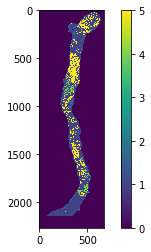

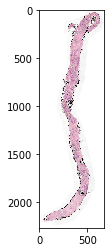

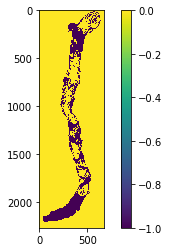

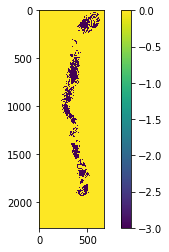

In [294]:
img_id = 22
image = skimage.io.MultiImage(str(filtered_img_paths_train[img_id ]))[2]
mask = skimage.io.MultiImage(str(filtered_mask_paths_train[img_id ]))[2]

print(filtered_mask_paths[img_id ])

plt.imshow(mask[:,:,0])
plt.colorbar()
plt.figure()
plt.imshow(image)

img = 1 - (image.astype('float32') / 255)
pred = new_model.predict(img[np.newaxis,...])

plt.figure()
plt.imshow(pred[0,...,1])
plt.colorbar()
plt.figure()
plt.imshow(pred[0,...,2])
plt.colorbar()

print(image.shape)

In [298]:
image = skimage.io.MultiImage(str(filtered_img_paths[img_id ]))[2]
print("level 2 image shape", image.shape)
lv2 = get_tile_coords(image, 60, 36, 255)

image = skimage.io.MultiImage(str(filtered_img_paths[img_id ]))[1]
print("level 1 image shape", image.shape)

lv1 = get_tile_coords(image, 240, 36, 255)

lvpred = get_tile_coords(pred[0,...], 60, 36, 0)

print(np.concatenate((lv1 / 4, lvpred), axis=1))

level 2 image shape (2272, 672, 3)
level 1 image shape (9088, 2688, 3)
[[ 900.  300.  120.  420.]
 [  60.  540. 1680.  420.]
 [ 960.  300. 1440.  360.]
 [ 180.  480.  600.  300.]
 [1860.  420.  660.  300.]
 [1020.  240.  540.  360.]
 [ 720.  360.  660.  360.]
 [ 960.  240. 1080.  300.]
 [1500.  360.  600.  360.]
 [1680.  420. 1020.  240.]
 [ 120.  420.  120.  540.]
 [ 480.  360.  960.  240.]
 [ 600.  300.  120.  480.]
 [1560.  420. 1500.  360.]
 [1380.  300.   60.  480.]
 [  60.  480.  480.  360.]
 [1140.  300.  900.  240.]
 [1440.  360.  840.  300.]
 [ 840.  300. 1860.  420.]
 [ 120.  540. 1380.  360.]
 [ 720.  300.  540.  300.]
 [1740.  420.  900.  300.]
 [ 660.  360.  720.  300.]
 [ 180.  420.  780.  300.]
 [ 540.  360.  840.  240.]
 [ 240.  420.  180.  420.]
 [ 180.  360.  180.  480.]
 [ 120.  480. 1140.  300.]
 [1380.  360.   60.  540.]
 [ 600.  360.  720.  360.]
 [ 660.  300. 1740.  420.]
 [1200.  360. 1260.  300.]
 [1080.  300. 1560.  420.]
 [ 840.  240. 1620.  420.]
 [ 720.  24

In [299]:
result = []
resultOld = []
resultMask = []
sz = 240

shape = image.shape
print("shape before padding", shape)
# Padding is only needed if the image cannot be tiled exactly into N tiles
# in this case, the image is padded with the size it would be missing
pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz

# Pad the image into size [W + pad0, H + pad1, C]
# from now on: W = W + pad0, H = H + pad1
image = np.pad(image,
             [[0, pad0],
              [0, pad1],
              [0, 0]],
             constant_values=255)
print("shape after padding", image.shape)

#plt.imshow(image)

for x,y in lvpred * 4:
    result.append(image[x:x + sz, y:y+sz, :])
    resultMask.append(image[x:x + sz, y:y+sz, :])
    
for x,y in lv1:
    resultOld.append(image[x:x + sz, y:y+sz, :])


shape before padding (9088, 2688, 3)
shape after padding (9120, 2880, 3)


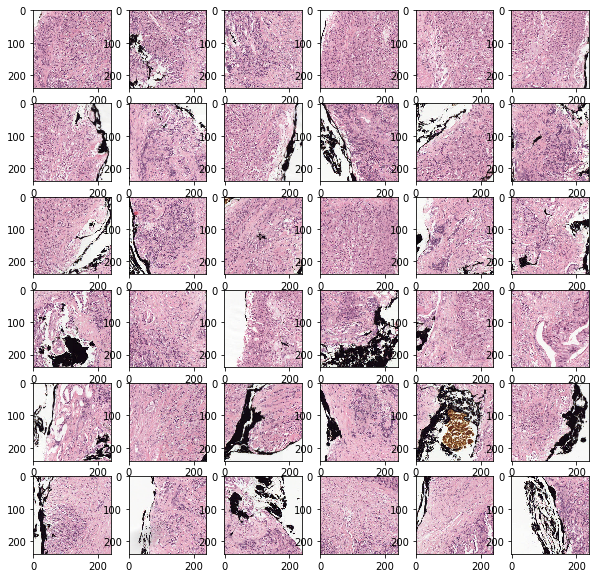

In [300]:
new = np.array(result)
old = np.array(resultOld)

sz1 = 6
sz2 = 6
fig, ax = plt.subplots(sz1, sz2, figsize=(10,10))

k = 0
for i in range(0,sz1):
    for j in range(0,sz2):
        ax[i,j].imshow(new[k,...])
        k+=1
plt.show()

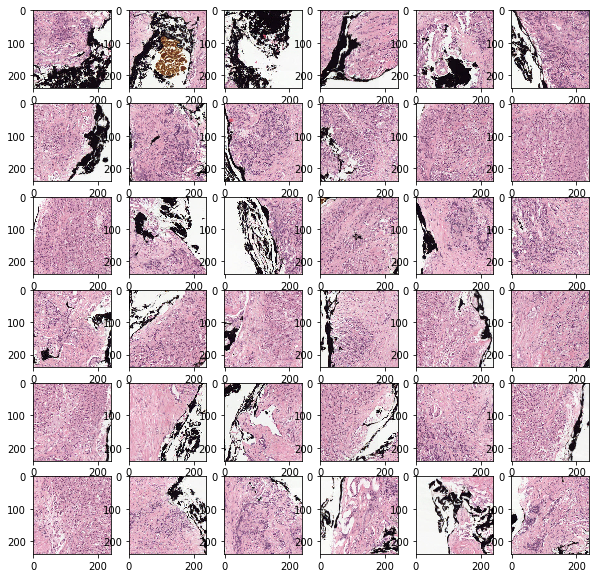

In [301]:
fig, ax = plt.subplots(sz1, sz2, figsize=(10,10))

k = 0
for i in range(0,sz1):
    for j in range(0,sz2):
        ax[i,j].imshow(old[k,...])
        k+=1
plt.show()